Graphs with features

Imports

In [1]:
import pandas as pd
import pandana as pdna
from pandana.loaders import osm
import numpy as np
import warnings
import matplotlib.pyplot as plt
from pathlib import Path
import geopandas as gpd
import osmnx as ox
import os
import timeit

ox.settings.use_cache = True

ox.settings.log_console = True


Save load graphs

In [2]:
start = timeit.timeit() #timing
#osmnx
filepath = "./data/copenhagen_network.graphml"
places = ["Copenhagen Municipality, Denmark", "Frederiksberg Municipality, Denmark", "Tårnby Municipality, Denmark", "Dragør Municipality, Denmark",]
if(os.path.exists(filepath)):
    G = ox.io.load_graphml(filepath)
else:
    ##bbox = 12.4763, 55.5504, 12.6878, 55.7016
    ##G = ox.graph.graph_from_bbox(bbox, simplify = True, network_type="walk")  
    G = ox.graph.graph_from_place(places, simplify = True, network_type="walk")
    ox.io.save_graphml(G, filepath)

G = ox.project_graph(G)

#pandana
filepath_pan = "./data/copenhagen_features.h5"

if(os.path.exists(filepath_pan)):
    n, e = ox.graph_to_gdfs(G)
    e = e.reset_index()
    network = pdna.Network.from_hdf5(filepath_pan)
else:
    n, e = ox.graph_to_gdfs(G)
    e = e.reset_index()
    network = pdna.Network(n.geometry.x, n.geometry.y, e["u"], e["v"], e[["length"]])
    
    network.save_hdf5(filepath_pan)

places = ["Copenhagen Municipality, Denmark", "Frederiksberg Municipality, Denmark", "Tårnby Municipality, Denmark", "Dragør Municipality, Denmark",]

pois = ox.features_from_place(
    places,
    tags={"amenity": "library", "amenity": "pharmacy", "amenity": "bus_station", "shop": "supermarket", "shop": "mall"},
).to_crs(n.crs)

pois = pois.copy()
pois["geometry"] = pois.geometry.centroid

dist = 1000

network.set_pois(
    category="pois",
    maxdist=2000,
    maxitems=1000,
    x_col=pois.geometry.x,
    y_col=pois.geometry.y,
)

nearest_pois = network.nearest_pois(
    distance=2000,
    category="pois",
    num_pois=1000,
)
n["pois"] = (nearest_pois <= dist).sum(axis=1)

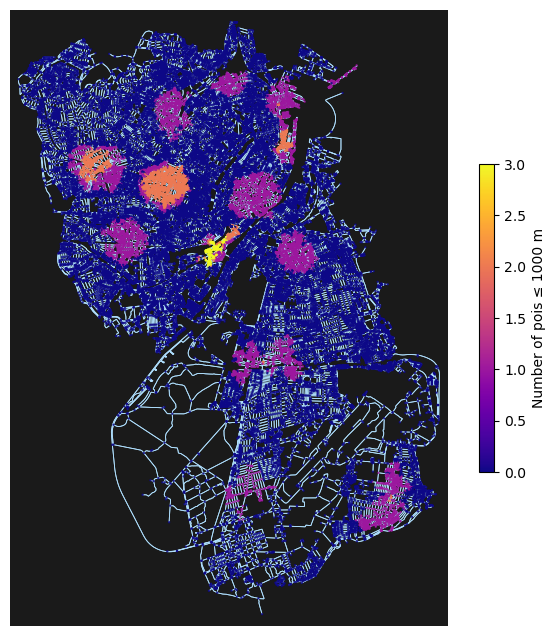

In [3]:
fig, ax = ox.plot.plot_graph(
    G,
    node_size=0,
    edge_color="#afdffe",
    edge_linewidth=0.6,
    bgcolor="#1a1a1a",
    show=False,
    close=False
)

vmin = n["pois"].min()
vmax = n["pois"].max()

n.plot(
    ax=ax,
    column="pois",
    cmap="plasma",
    markersize=0.5,
    alpha=0.8,
    legend=True,
    legend_kwds={
        "shrink": 0.5,
        "label": f"Number of pois ≤ {dist} m",
        "orientation": "vertical"
    },
    vmin=0,
    vmax=vmax
)

plt.show()